## TODO

- add the measurement of actual allocation of resources to vertices
- add the measurement of rate of change of resource allocation to vertices
- add the measurement of variance of resource allocation to vertices

In [55]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [56]:
import networkx as nx
import numpy as np
import pandas as pd

import statistics

import sys
sys.path.append('../..')

from tqdm import tqdm_notebook as tqdm

from collections import namedtuple, UserDict
from functools import lru_cache

from sklearn.preprocessing import MinMaxScaler

tqdm.monitor_interval = 0

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Tuple, Dict

from networkentropy import network_energy as ne
from networkentropy import network_utils as nu

from networkentropy.utils import gini, theil, normalize_dict
from networkentropy.network_utils import NetworkDict, Dataset

In [57]:
def initial_allocation(g, budget, allocations, copy=True):
    '''
    Performs an initial allocation of a given budget of a resource to all vertices of a given network, using provided allocation schemes
    
    Args:
        g: graph to be annotated
        budget: summary budget of allocation
        allocations: dict of allocation schemes
        copy: specifies if the graph g should be copied before modifitations
        
    Returns:
        graph g with node attributes representing allocations
    '''
    
    if copy:
        g = g.copy()

    for name, method in allocations.items():
        initial_values = method(g)
        if initial_values:
            nx.set_node_attributes(g, normalize_dict(initial_values, target=budget), name)

    return g

In [58]:
# definition of a single iteration where each vertex sends resources to a randomly chosen neighbor

def do_turn(graph, allocations):
    '''
    Performs a single iteration of resource exchange
    
    Args:
        graph: input graph
        allocations: list of names of attributes which hold the initial allocation
    '''
    jump_ratio = [1/i**2 for i in range(1,6)]
    jump_prob = [jr/sum(jump_ratio) for jr in jump_ratio]

    radius = np.random.choice(range(1,6), p=jump_prob )

    for node in graph.nodes:
        neighbors = list(set(nx.ego_graph(graph, node, radius=radius).nodes()).difference([node]))
        
        if len(neighbors) > 0:
            # select a neighbor to trade resources with
            neighbor = np.random.choice(neighbors)

            # select amount to trade
            amount = 0.001

            for allocation in allocations:

                if allocation in graph.nodes[node].keys():
                    if graph.nodes[node][allocation] > amount:
                        graph.nodes[node][allocation] -= amount
                        graph.nodes[neighbor][allocation] += amount
                
    return

In [59]:
IterationEntry = namedtuple('IterationEntry', ['network','iteration','allocation','inequality_level', 'inequality'])

def run_network(g, budget, allocations, num_iterations):
    '''
    Creates initial allocation and simulates the flow of resources within the network
    
    Args:
        g: input graph
        budget: initial amount of resource to be distributed
        allocations: list of names of attributes which hold the initial allocation
        num_iterations: number of iterations of resource exchange
        
    '''
    result = []
    # helper function which computes the sum of resource allocation
    # for a given vertex' egocentric network
    sum_ego_graph_resource = lambda g, node, resource, radius: sum([g.nodes[n][resource] for n in nx.ego_graph(g, node, radius=radius).nodes if resource in g.nodes[n].keys()])

    graph_name = g.graph['name']
    
    # select the greatest connected component of a network
    g = nx.subgraph(g, max(nx.connected_components(g.to_undirected()), key=len))
    
    g = initial_allocation(g, budget=budget, allocations=allocations)
    
    for i in tqdm(range(num_iterations)):
        
        do_turn(g, allocations)

        for allocation in allocations:

            vertex_resource_distribution = np.array(list(nx.get_node_attributes(g, allocation).values()))
            egonet_resource_distribution = np.array([sum_ego_graph_resource(g, n, allocation, 1) for n in g.nodes])

            result.append(IterationEntry(graph_name, i, allocation, 'vertex_distribution_gini', gini(vertex_resource_distribution)))
            result.append(IterationEntry(graph_name, i, allocation, 'egonet_distribution_gini', gini(egonet_resource_distribution)))
            result.append(IterationEntry(graph_name, i, allocation, 'vertex_distribution_theil', theil(vertex_resource_distribution)))
            result.append(IterationEntry(graph_name, i, allocation, 'egonet_distribution_theil', theil(egonet_resource_distribution)))

    return result

In [60]:
# helper methods for drawing networks and plots

def draw_inequality(df, name, title, last_num=None, measure='gini'):
    
    distribution_idx = df['inequality_level'] == f'{name}_{measure}'
    
    if last_num is None:
        data_df =  df[distribution_idx]
    else:
        data_df = df[distribution_idx][-last_num:]
        
    sns.lineplot(data=data_df, x='iteration', y='inequality', style='allocation')

def draw_inequalities(df):
    
    draw_inequality(df, 'vertex_distribution', 'Gini vertex inequality', measure='gini')
    plt.show()
    draw_inequality(df, 'vertex_distribution', 'Theil vertex inequality', measure='theil')
    plt.show()
    draw_inequality(df, 'egonet_distribution', 'Gini egonet inequality', measure='gini')
    plt.show()
    draw_inequality(df, 'egonet_distribution', 'Theil egonet inequality', measure='theil')
    plt.show()

In [61]:
def get_min_inequlity_method(df, dist):
    idx = empirical_df\
    .query("iteration == (@NUM_ITERS - 1) and inequality_level == @dist")\
    .groupby('network')['inequality'].idxmin()
    return empirical_df.loc[idx]

In [62]:
# Constants definitions

SEED = 10
N = 100
P_ERDOS_RENYI = 0.025
P_HOLME_KIM = 0.1
M_HOLME_KIM = 2
K_K_OUT = 3
K_ALPHA = 1

In [63]:
NETWORKS_CREATORS = NetworkDict({
    'erdos-renyi-1': lambda: nx.erdos_renyi_graph(n=N, p=P_ERDOS_RENYI, seed=SEED),
    'erdos-renyi-2': lambda: nx.erdos_renyi_graph(n=N, p=P_ERDOS_RENYI+0.01, seed=SEED),
    'erdos-renyi-3': lambda: nx.erdos_renyi_graph(n=N, p=P_ERDOS_RENYI-0.01, seed=SEED),
    'erdos-renyi-4': lambda: nx.erdos_renyi_graph(n=N, p=P_ERDOS_RENYI+0.02, seed=SEED),
    'erdos-renyi-5': lambda: nx.erdos_renyi_graph(n=N, p=P_ERDOS_RENYI-0.02, seed=SEED),
    'holme-kim-1': lambda: nx.powerlaw_cluster_graph(n=N, m=M_HOLME_KIM, p=P_HOLME_KIM),
    'holme-kim-2': lambda: nx.powerlaw_cluster_graph(n=N, m=M_HOLME_KIM, p=P_HOLME_KIM+0.1),
    'holme-kim-3': lambda: nx.powerlaw_cluster_graph(n=N, m=M_HOLME_KIM, p=P_HOLME_KIM+0.2),
    'holme-kim-4': lambda: nx.powerlaw_cluster_graph(n=N, m=M_HOLME_KIM+1, p=P_HOLME_KIM),
    'holme-kim-5': lambda: nx.powerlaw_cluster_graph(n=N, m=M_HOLME_KIM+2, p=P_HOLME_KIM),
    'scale-free-1': lambda: nx.DiGraph(nx.scale_free_graph(n=N, alpha=0.41, beta=0.54, gamma=0.05)),
    'scale-free-2': lambda: nx.DiGraph(nx.scale_free_graph(n=N, alpha=0.31, beta=0.64, gamma=0.05)),
    'scale-free-3': lambda: nx.DiGraph(nx.scale_free_graph(n=N, alpha=0.41, beta=0.49, gamma=0.10)),
    'scale-free-4': lambda: nx.DiGraph(nx.scale_free_graph(n=N, alpha=0.31, beta=0.59, gamma=0.10)),
    'scale-free-5': lambda: nx.DiGraph(nx.scale_free_graph(n=N, alpha=0.43, beta=0.56, gamma=0.01)),
    'k-out-1': lambda: nx.DiGraph(nx.random_k_out_graph(n=N, k=K_K_OUT, alpha=K_ALPHA, self_loops=False, seed=SEED)),
    'k-out-2': lambda: nx.DiGraph(nx.random_k_out_graph(n=N, k=K_K_OUT+1, alpha=K_ALPHA, self_loops=False, seed=SEED)),
    'k-out-3': lambda: nx.DiGraph(nx.random_k_out_graph(n=N, k=K_K_OUT-1, alpha=K_ALPHA, self_loops=False, seed=SEED)),
    'k-out-4': lambda: nx.DiGraph(nx.random_k_out_graph(n=N, k=K_K_OUT, alpha=K_ALPHA+0.5, self_loops=False, seed=SEED)),
    'k-out-5': lambda: nx.DiGraph(nx.random_k_out_graph(n=N, k=K_K_OUT, alpha=K_ALPHA-0.5, self_loops=False, seed=SEED)),
})

In [64]:
ALLOCATIONS = {
    'random': lambda g: { node: np.random.random() for node in g.nodes },
    'constant': lambda g: { node:1 for node in g.nodes },
    'pagerank': nx.pagerank,
    'randic_energy': ne.randic_centrality,
    'graph_energy': ne.graph_energy_centrality,
    'laplacian_energy': ne.laplacian_centrality,
    'randic_pagerank': lambda g: { k: v for k,v in ne.graph_energy_pagerank(g, mode='randic').items()},
    'graph_pagerank': lambda g: { k: v for k,v in ne.graph_energy_pagerank(g, mode='graph').items()},
    'laplacian_pagerank': lambda g: { k: v for k,v in ne.graph_energy_pagerank(g, mode='laplacian').items()},
    'randic_gradient': lambda g: { k: v for k,v in ne.gradient_centrality(g, mode='randic').items()}, 
    'graph_gradient': lambda g: { k: v for k,v in ne.gradient_centrality(g, mode='graph').items()},
    'laplacian_gradient': lambda g: { k: v for k,v in ne.gradient_centrality(g, mode='laplacian').items()},
}

In [65]:
BUDGET = 1
NUM_ITERS = 500

In [ ]:
synthetic_dfs = []

In [66]:
network_name, network_creator = list(NETWORKS_CREATORS.items())[13]
g = network_creator()
results = run_network(g, BUDGET, ALLOCATIONS, NUM_ITERS)
df = pd.DataFrame(list(map(lambda e: e._asdict(), results)))

../../networkentropy/utils.py:72: RuntimeWarning: divide by zero encountered in log
  theil_index = (1 / N) * np.nansum((x / mi) * np.log(x / mi))
../../networkentropy/utils.py:72: RuntimeWarning: invalid value encountered in multiply
  theil_index = (1 / N) * np.nansum((x / mi) * np.log(x / mi))


/home/mikolaj/Research/entropy-complex-networks/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mikolaj/Research/entropy-complex-networks/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


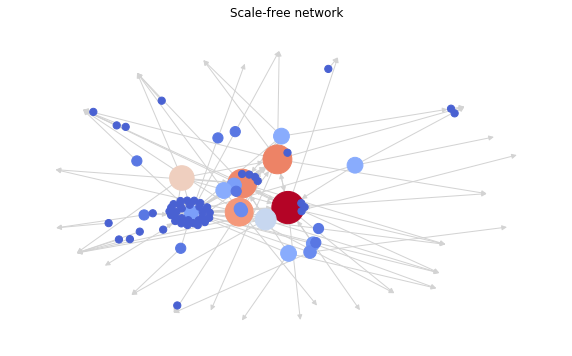

In [71]:
size_factor=10000

values = ne.laplacian_centrality(g, normalized=True).values()

options = { 
    'node_color': [d for d in list(values)],
    'node_size': [d * size_factor for d in list(values)],
    'cmap': plt.cm.coolwarm,
    'edge_color': 'lightgray',
    'pos': nx.spring_layout(g),
}

plt.figure(figsize=(10, 6))
plt.title('Scale-free network')
nx.draw(g, **options)
plt.show()

/home/mikolaj/Research/entropy-complex-networks/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mikolaj/Research/entropy-complex-networks/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


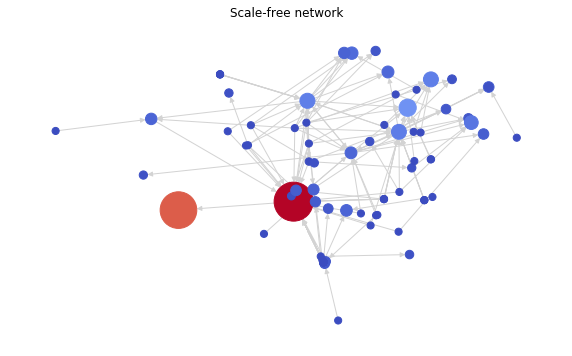

In [68]:
size_factor=10000

values = ne.gradient_centrality(g, mode='laplacian', normalized=True).values()

options = { 
    'node_color': [d for d in list(values)],
    'node_size': [d * size_factor for d in list(values)],
    'cmap': plt.cm.coolwarm,
    'edge_color': 'lightgray',
    'pos': nx.kamada_kawai_layout(g),
}

plt.figure(figsize=(10, 6))
plt.title('Scale-free network')
nx.draw(g, **options)
plt.show()

In [ ]:
df.allocation.unique()

In [ ]:
idx = df.allocation.apply(lambda x: x in ['constant', 'pagerank', 'randic_energy'])

sns.set_style('whitegrid')

draw_inequalities(df[idx])

In [ ]:
for network_name, network_creator in tqdm(list(NETWORKS_CREATORS.items())):
    g = network_creator()
    results = run_network(g, BUDGET, ALLOCATIONS, NUM_ITERS)
    df = pd.DataFrame(list(map(lambda e: e._asdict(), results)))
    synthetic_dfs.append(df)

In [23]:
def get_min_inequlity_method(df, dist):
    idx = df\
        .query("iteration == (@NUM_ITERS - 1) and inequality_level == @dist")\
        .groupby('network')['inequality'].idxmin()
    return df.loc[idx]

In [24]:
def calculate_avg_rate_of_change_and_variance(df):
    result = {
        'avg_roc': [(df.loc[df['iteration'] == NUM_ITERS-1].iloc[0]['inequality'] - df.loc[df['iteration'] == 0].iloc[0]['inequality'])/NUM_ITERS],
        'variance': [statistics.pvariance(df['inequality'])],
    } 
    return pd.DataFrame(result)

def group_and_calculate_avg_roc_and_variance(df):
    return df.groupby(['network', 'allocation', 'inequality_level'])\
.apply(calculate_avg_rate_of_change_and_variance)

In [25]:
def get_min_statistic_method(df, statistic, dist):
    idx = df.query("inequality_level == @dist").groupby('network')[statistic].idxmin()
    return df.loc[idx, statistic].to_frame()

In [21]:
synthetic_df.head()

,index,network,iteration,allocation,inequality_level,inequality
0,0,erdos-renyi-1,0,random,vertex_distribution_gini,0.368301
1,1,erdos-renyi-1,0,random,egonet_distribution_gini,0.269595
2,2,erdos-renyi-1,0,random,vertex_distribution_theil,0.226165
3,3,erdos-renyi-1,0,random,egonet_distribution_theil,0.118297
4,4,erdos-renyi-1,0,constant,vertex_distribution_gini,0.042814


In [ ]:
synthetic_df = pd.concat(synthetic_dfs).reset_index()

In [26]:
get_min_inequlity_method(synthetic_df, 'vertex_distribution_gini').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
constant           17
randic_energy       1
randic_pagerank     1
Name: network, dtype: int64

In [27]:
get_min_inequlity_method(synthetic_df, 'vertex_distribution_theil').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
constant         14
graph_energy      3
randic_energy     1
Name: network, dtype: int64

In [28]:
get_min_inequlity_method(synthetic_df, 'egonet_distribution_gini').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
constant        5
random          4
graph_energy    3
Name: network, dtype: int64

In [29]:
get_min_inequlity_method(synthetic_df, 'egonet_distribution_theil').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
constant        5
random          4
graph_energy    3
Name: network, dtype: int64

In [30]:
synthetic_avg_roc_and_variance_df = group_and_calculate_avg_roc_and_variance(synthetic_df)

In [31]:
get_min_statistic_method(synthetic_avg_roc_and_variance_df, 'avg_roc', 'vertex_distribution_gini').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
randic_gradient    8
graph_pagerank     4
graph_energy       3
Name: network, dtype: int64

In [32]:
get_min_statistic_method(synthetic_avg_roc_and_variance_df, 'avg_roc', 'vertex_distribution_theil').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
randic_gradient       5
laplacian_gradient    4
graph_energy          3
Name: network, dtype: int64

In [33]:
get_min_statistic_method(synthetic_avg_roc_and_variance_df, 'avg_roc', 'egonet_distribution_gini').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
graph_energy       6
randic_gradient    4
graph_gradient     3
Name: network, dtype: int64

In [34]:
get_min_statistic_method(synthetic_avg_roc_and_variance_df, 'avg_roc', 'egonet_distribution_theil').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
graph_energy       6
randic_gradient    5
graph_gradient     3
Name: network, dtype: int64

In [35]:
get_min_statistic_method(synthetic_avg_roc_and_variance_df, 'variance', 'vertex_distribution_gini').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
randic_gradient    7
graph_energy       4
graph_pagerank     4
Name: network, dtype: int64

In [36]:
get_min_statistic_method(synthetic_avg_roc_and_variance_df, 'variance', 'vertex_distribution_theil').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
randic_gradient       6
laplacian_gradient    5
graph_gradient        3
Name: network, dtype: int64

In [39]:
get_min_statistic_method(synthetic_avg_roc_and_variance_df, 'variance', 'egonet_distribution_gini').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
randic_gradient       7
graph_energy          5
laplacian_gradient    3
Name: network, dtype: int64

In [41]:
get_min_statistic_method(synthetic_avg_roc_and_variance_df, 'variance', 'egonet_distribution_theil').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
randic_gradient       5
graph_gradient        4
laplacian_gradient    4
Name: network, dtype: int64

In [ ]:
BUDGET = 1
NUM_ITERS = 500

MIN_NODES, MAX_NODES = 20, 1000
MIN_DENSITY, MAX_DENSITY = 0.02, 0.9
BIPARTITE = False
DIRECTED = True

In [ ]:
networks_raw = nu.read_available_datasets_konect(name='konect.cc').filter(
    bipartite=BIPARTITE, min_size=MIN_NODES, max_size=MAX_NODES, min_density=MIN_DENSITY, max_density=MAX_DENSITY)

In [ ]:
tabu_list = ['contact', 'sociopatterns-infectious', 'opsahl-ucsocial']

In [ ]:
networks = []

for n in tqdm(networks_raw):
    network = Dataset(*n)
    if network.name not in tabu_list:
        networks.append(nu.build_network_from_out_konect(network_name=network.name, 
                                                     tsv_url=network.tsv_url,
                                                     directed=network.directed,
                                                     dir_name=f'data/'))

In [ ]:
empirical_dfs = []

In [ ]:
networks = [n for n in networks if n]

df_networks = pd.DataFrame(
{
    'name': [g.graph['name'] for g in networks],
    'n_nodes': [nx.number_of_nodes(g) for g in networks],
    'n_edges': [nx.number_of_edges(g) for g in networks],
    'density': [nx.density(g) for g in networks] 
}, index=range(len(networks)))

df_networks

In [ ]:
print(df_networks.sort_values(by='n_nodes').to_latex(index=False))

In [ ]:
%%time

for (i, g) in tqdm(enumerate(networks)):
    
    if i < (len(empirical_dfs) - 1):
        df = empirical_dfs[i]
    else:        
        results = run_network(g, BUDGET, ALLOCATIONS, NUM_ITERS)
        df = pd.DataFrame(list(map(lambda e: e._asdict(), results)))
        empirical_dfs.append(df)

#     display(HTML(f"<h2>{g.graph['name']}</h2>"))               
#     draw_graph(g, calculate_graph_energy, title_postfix=', graph energy')
#     draw_graph(g, calculate_graph_gradient_centrality, title_postfix=', energy gradient centrality', size_factor=5e4)
#     sns.set(rc={'figure.figsize':(11.7,8.27)})
#     draw_inequalities(df)

## Final minimal inequality

### Vertex distribution

In [ ]:
empirical_df = pd.concat(empirical_dfs).reset_index()

In [42]:
get_min_inequlity_method(empirical_df, 'vertex_distribution_gini').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
randic_energy    17
constant          6
pagerank          2
Name: network, dtype: int64

In [43]:
get_min_inequlity_method(empirical_df, 'vertex_distribution_theil').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
randic_energy     17
constant           6
graph_gradient     2
Name: network, dtype: int64

### Egocentric distribution

In [44]:
get_min_inequlity_method(empirical_df, 'egonet_distribution_gini').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
randic_energy         16
graph_energy           3
laplacian_gradient     3
Name: network, dtype: int64

In [45]:
get_min_inequlity_method(empirical_df, 'egonet_distribution_theil').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
randic_energy    16
graph_energy      4
random            3
Name: network, dtype: int64

In [46]:
avg_roc_df = group_and_calculate_avg_roc_and_variance(empirical_df)

## Rate of Change 

### Vertex distribution

Intrestingly, we can see that gradient alocation methods often have the lowest average rate of change of inequality over iterations

In [47]:
get_min_statistic_method(avg_roc_df, 'avg_roc', 'vertex_distribution_gini').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
graph_energy          17
laplacian_gradient     4
randic_gradient        3
Name: network, dtype: int64

In [48]:
get_min_statistic_method(avg_roc_df, 'avg_roc', 'vertex_distribution_theil').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
graph_energy          16
laplacian_energy       4
laplacian_gradient     3
Name: network, dtype: int64

### Egocentric distribution

In [49]:
get_min_statistic_method(avg_roc_df, 'avg_roc', 'egonet_distribution_gini').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
laplacian_energy    12
graph_energy        11
randic_energy        2
Name: network, dtype: int64

In [50]:
get_min_statistic_method(avg_roc_df, 'avg_roc', 'egonet_distribution_theil').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
laplacian_energy    12
graph_energy        11
graph_gradient       2
Name: network, dtype: int64

## Variance

### Vertex distribution

Intrestingly, we can see that gradient methods often have the lowest variance of inequality over iterations

In [51]:
get_min_statistic_method(avg_roc_df, 'variance', 'vertex_distribution_gini').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
graph_energy          15
laplacian_gradient     5
graph_pagerank         3
Name: network, dtype: int64

In [52]:
get_min_statistic_method(avg_roc_df, 'variance', 'vertex_distribution_theil').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
graph_energy          15
laplacian_gradient     6
pagerank               2
Name: network, dtype: int64

### Egocentric distribution

In [53]:
get_min_statistic_method(avg_roc_df, 'variance', 'egonet_distribution_gini').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
graph_energy          16
randic_gradient        4
laplacian_gradient     3
Name: network, dtype: int64

In [54]:
get_min_statistic_method(avg_roc_df, 'variance', 'egonet_distribution_theil').reset_index().groupby('allocation')['network'].count().nlargest(3)

allocation
graph_energy       16
randic_gradient     4
graph_gradient      2
Name: network, dtype: int64

In [ ]:
import pickle

with open('energy-gradient-alocation.pkl','wb') as f:
    pickle.dump([synthetic_df, empirical_df], f)

In [16]:
import pickle

with open('energy-gradient-alocation.pkl','rb') as f:
    synthetic_df, empirical_df = pickle.load(f)